# Step 3. Rotate cell locations (x, y) to align with the canonical directions of coronal brain slices
- inputs: `preprocessed_merfish_ad_mouse.hdf5`
- output: `preprocessed_merfish_ad_mouse_rotated.hdf5`

In [1]:
import sys
sys.path.insert(0, 'W:/Lab/MERFISH_Data_060421/SingleCellRoutines')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from matplotlib.cm import get_cmap
import fbpca
import datetime
import seaborn as sns

from __init__scr import *
from __init__plots import *

In [2]:
today = datetime.date.today()

# Read in data 
- meta
- data

# Output data
- meta (new x, y, columns)
- data
- rotation mat

In [3]:
DATA_DIR='W:/Lab/MERFISH_Data_060421/New_Vizgen_data_071621/data/'

In [4]:
input = DATA_DIR+'processed_merfish_ad_mouse.hdf5'
output_file = DATA_DIR+'processed_merfish_ad_mouse_rotated.hdf5'
samples = [
    'New_Vizgen_data_071621',
]

alldata = {}
metas = {}
datas = {}
for sample in samples:
    # one sample
    meta = pd.read_hdf(input, 'meta_'+sample)
    meta['sample'] = sample 
    
    data = pd.read_hdf(input, 'mat_'+sample)
    
    toplot = meta.join(data)
    
    metas[sample] = meta
    datas[sample] = data
    alldata[sample] = toplot
    

# Rotation 

In [5]:
# rotation transformation
def rotate(mat, vec_chiral):
    """(n,2) matrix as input
    """
    U, s, Vt = fbpca.pca(mat, k=2)
    coords = U.dot(np.diag(s))

    # det = -1 reflection; det = 1 rotation
    if np.linalg.det(Vt) < 0: # ~ -1
        coords[:,0] = -coords[:,0]
        Vt[0,:] = -Vt[0,:]
        
    delta = vec_chiral[coords[:,1]>0].sum() - vec_chiral[coords[:,1]<0].sum()
    if delta < 0: # rotate 180 
        coords = -coords
        Vt = -Vt
    return coords, Vt

In [6]:
all_Vts = {}
for sample in alldata.keys():
    toplot = alldata[sample]
    toplot[['x', 'y']], Vt = rotate(toplot[['center_x', 'center_y']].values, toplot['Slc17a7'].values)
    
    all_Vts[sample] = Vt
    metas[sample][['x', 'y']] = toplot[['x', 'y']]

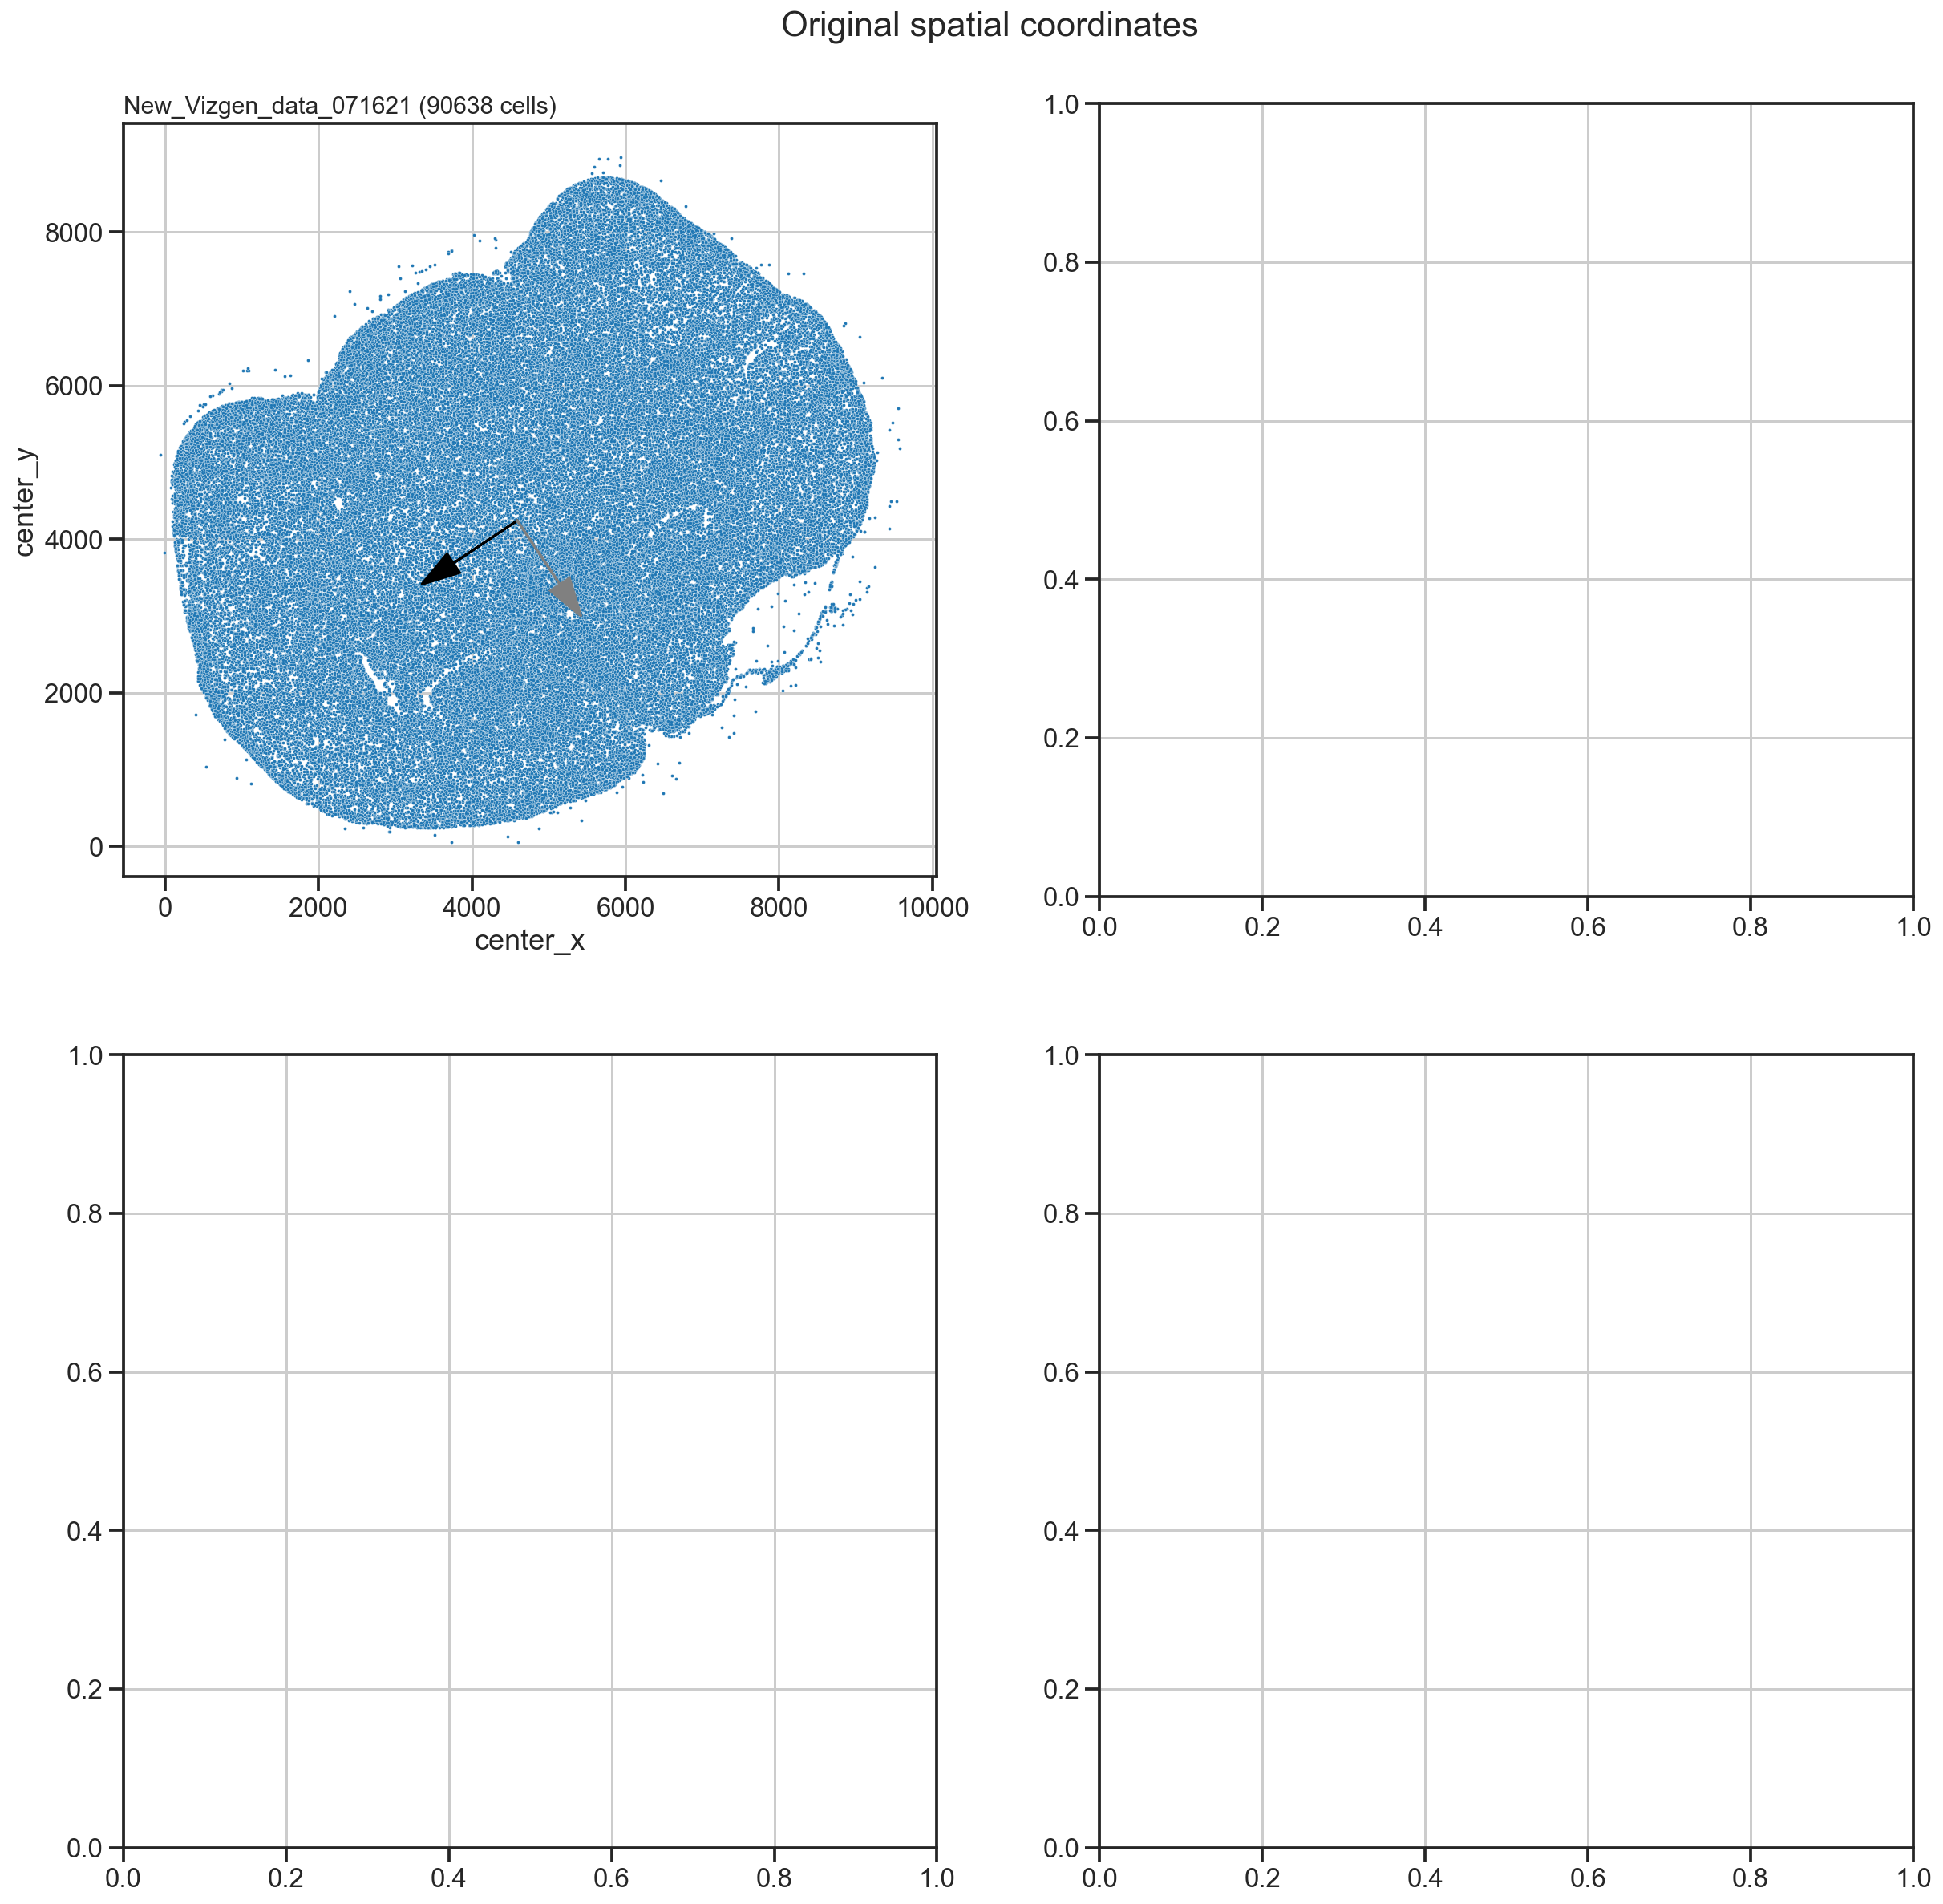

In [7]:
x, y, suptitle = 'center_x', 'center_y', 'Original spatial coordinates'
fig, axs = plt.subplots(2, 2, figsize=(20,20))
for i, (ax, sample) in enumerate(zip(axs.flat, alldata.keys())):
    toplot = alldata[sample]
    Vt = all_Vts[sample]
    
    sns.scatterplot(x=x, y=y, data=toplot, 
                    s=4, markers=dict(marker_edge_color='none'),
                    rasterized=True,
                    ax=ax,
                   )
    ax.set_aspect('equal')
    xmean, ymean = toplot[x].mean(), toplot[y].mean()
    scale = 1000
    ax.arrow(xmean, ymean, scale*Vt[0,0], scale*Vt[0,1], 
             head_width=0.3*scale, head_length=0.5*scale, fc='k', ec='k')
    ax.arrow(xmean, ymean, scale*Vt[1,0], scale*Vt[1,1], 
             head_width=0.3*scale, head_length=0.5*scale, fc='gray', ec='gray')
    ax.set_title("{} ({} cells)".format(sample, len(toplot)), loc='left', fontsize=15)
fig.suptitle(suptitle, y=0.92)
plt.show()

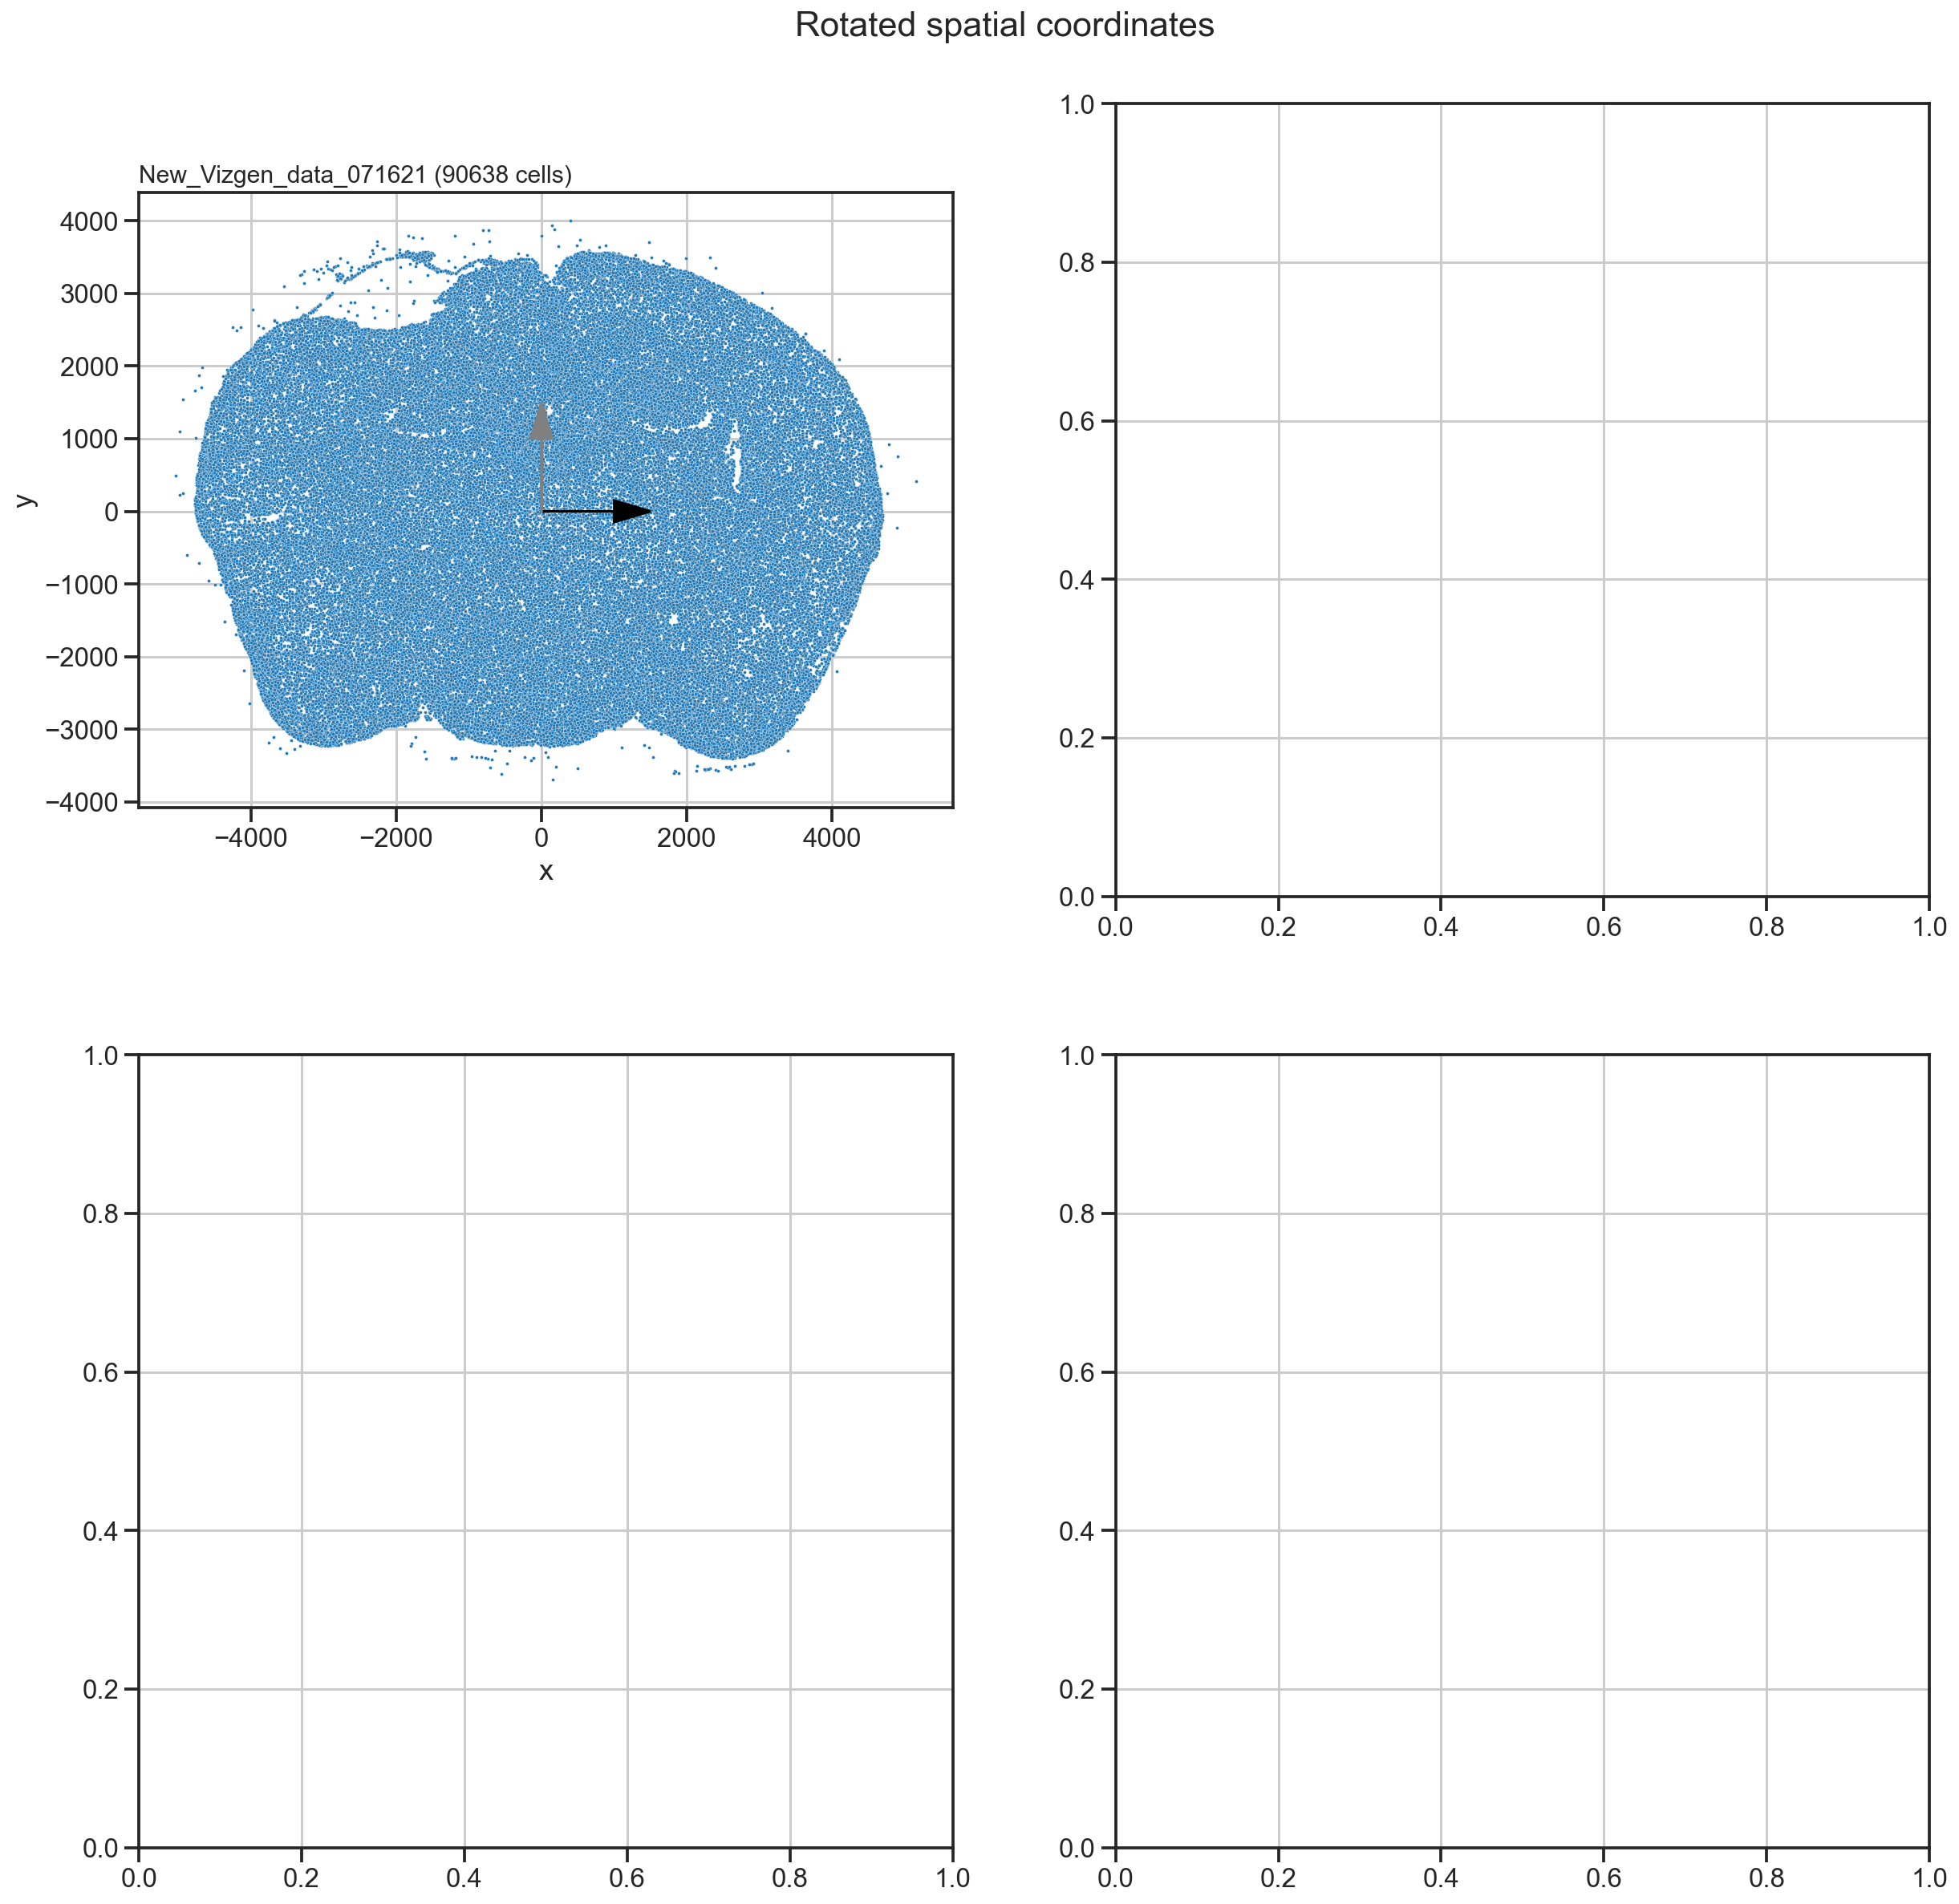

In [8]:
x, y, suptitle = 'x', 'y', 'Rotated spatial coordinates'
fig, axs = plt.subplots(2, 2, figsize=(20,20))
for i, (ax, sample) in enumerate(zip(axs.flat, alldata.keys())):
    toplot = alldata[sample]
    Vt = all_Vts[sample]
    Vt = Vt.dot(Vt.T)
    
    sns.scatterplot(x=x, y=y, data=toplot, 
                    s=4, markers=dict(marker_edge_color='none'),
                    rasterized=True,
                    ax=ax,
                   )
    ax.set_aspect('equal')
    xmean, ymean = toplot[x].mean(), toplot[y].mean()
    scale = 1000
    ax.arrow(xmean, ymean, scale*Vt[0,0], scale*Vt[0,1], 
             head_width=0.3*scale, head_length=0.5*scale, fc='k', ec='k')
    ax.arrow(xmean, ymean, scale*Vt[1,0], scale*Vt[1,1], 
             head_width=0.3*scale, head_length=0.5*scale, fc='gray', ec='gray')
    ax.set_title("{} ({} cells)".format(sample, len(toplot)), loc='left', fontsize=15)
fig.suptitle(suptitle, y=0.92)
plt.show()

# Save

In [9]:
# rm $file

In [10]:
# save alldata and rotation matrices as hdf5
import h5py
file = output_file
for sample in alldata.keys():
    with h5py.File(file, 'a') as f:
        f['Vt_'+sample] = all_Vts[sample]
    metas[sample].to_hdf(file, 'meta_'+sample, 'a')
    datas[sample].to_hdf(file, 'mat_'+sample, 'a')

In [11]:
with h5py.File(file, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['Vt_New_Vizgen_data_071621', 'mat_New_Vizgen_data_071621', 'meta_New_Vizgen_data_071621']>


In [12]:
df = pd.read_hdf(file, 'meta_'+samples[0])
df

fov      volume     center_x  \
286781274239884258892500933826268215712     2  476.714412   -57.772439   
114753908720435791039249073573904856486     3  341.147348   123.698882   
239404862608611027566742101554810945676     3  133.773023   101.990881   
250055944479847701040859542242186078605     3  798.121022   130.556882   
286151967873247613350225133395413197201     3  563.814228   120.026881   
...                                       ...         ...          ...   
220899816656851915359567811738984697873  1589  493.818152  9575.403974   
312421505632637477107610858581302726631  1589   73.919729  9553.047973   
115039890283301310200685179207213197990  1590  313.513115  9481.693839   
194327846309246638069125315824700455880  1590   66.062275  9433.741837   
106530824559107026149356993963175879183  1591  456.576864  9547.169848   

                                            center_y        min_x  \
286781274239884258892500933826268215712  5097.648509   -69.771239   
114753908720435791039249073573904856486  4864.357704   118.504081   
239404862608611027566742101554810945676  4878.937704    99.064081   
250055944479847701040859542242186078605  4987.153707   121.312082   
286151967873247613350225133395413197201  4871.647704   114.184081   
...                                              ...          ...   
220899816656851915359567811738984697873  5188.623642  9563.189174   
312421505632637477107610858581302726631  5301.753645  9550.337173   
115039890283301310200685179207213197990  5515.228641  9472.233038   
194327846309246638069125315824700455880  5422.132639  9428.061037   
106530824559107026149356993963175879183  5701.771399  9537.547048   

                                               max_x        min_y  \
286781274239884258892500933826268215712   -45.773639  5088.619709   
114753908720435791039249073573904856486   128.893682  4859.540904   
239404862608611027566742101554810945676   104.917681  4875.416904   
250055944479847701040859542242186078605   139.801682  4981.148907   
286151967873247613350225133395413197201   125.869682  4863.104904   
...                                              ...          ...   
220899816656851915359567811738984697873  9587.618774  5180.566842   
312421505632637477107610858581302726631  9555.758773  5298.178845   
115039890283301310200685179207213197990  9491.154639  5503.877841   
194327846309246638069125315824700455880  9439.422637  5413.913839   
106530824559107026149356993963175879183  9556.792648  5692.310599   

                                               max_y  cell_cov  cell_cov_norm  \
286781274239884258892500933826268215712  5106.677309       1.0       0.451711   
114753908720435791039249073573904856486  4869.174504     126.0      79.533009   
239404862608611027566742101554810945676  4882.458504      30.0      48.291599   
250055944479847701040859542242186078605  4993.158507     145.0      39.121736   
286151967873247613350225133395413197201  4880.190504     234.0      89.371428   
...                                              ...       ...            ...   
220899816656851915359567811738984697873  5196.680442       1.0       0.436066   
312421505632637477107610858581302726631  5305.328445       1.0       2.913121   
115039890283301310200685179207213197990  5526.579442       1.0       0.686852   
194327846309246638069125315824700455880  5430.351439       1.0       3.259608   
106530824559107026149356993963175879183  5711.232199       1.0       0.471634   

                                                         sample            x  \
286781274239884258892500933826268215712  New_Vizgen_data_071621  3390.835409   
114753908720435791039249073573904856486  New_Vizgen_data_071621  3369.512106   
239404862608611027566742101554810945676  New_Vizgen_data_071621  3379.465113   
250055944479847701040859542242186078605  New_Vizgen_data_071621  3295.603035   
286151967873247613350225133395413197201  New_Vizgen_data_071621  3368.516388   
...                                       